# Metodos para procesamiento de datos EDF

In [ ]:
import mne
from scipy.signal import find_peaks,peak_widths,peak_prominences, savgol_filter,butter, lfilter
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import pandas as pd
from  sklearn.cluster import KMeans
from sklearn import preprocessing
from  sklearn.model_selection import train_test_split

In [ ]:
"""
Toma la información contenida en data y retorna un matriz con  los datos de la ubicación de los picos 
data - Corresponde a la información contenida en un archivo edf
"""
def denoising(data):
    N = 10  # Filter order
    Wn = 0.3  # Cutoff frequency
    B, A = sci.signal.butter(N, Wn, output='ba')
    for i in range(len(data)):
        #print('here')
        smooth_data = sci.signal.filtfilt(B, A, data[i])
        #plt.figure()
        #plt.plot(data[i][:200], '-or', label='regular', alpha=0.3)
        data[i] = smooth_data
        #plt.plot(smooth_data[:200], '-*b', label='denoised', alpha=0.5)
        #plt.legend()
        #plt.show()

def detectar_picos(data):
    peaks = []
    for m in data:
        peaks_pos = find_peaks(m, distance=3, height=0.0003)
        peaks_neg = find_peaks(-m, distance=3,height=0.0003)
        x = np.concatenate((peaks_pos[0], peaks_neg[0]))
        x = np.sort(x)
        peaks.append(x)
    return peaks

def segmentacion_picos(raw_data, peaks):
    n_channels = 23
    resultados = []
    for i in range(len(peaks)):
        pico = []
        for j in range(len(peaks[i]) - 1):
            inicial = peaks[i][j]
            final = peaks[i][j + 1]
            if raw_data[i][inicial] > 0 and raw_data[i][final] < 0:

                pico.append(inicial)
                pico.append(final)
        resultados.append(pico)
    return resultados

def caracterizacion_picos(raw_data, resultados):
    respuesta = []
    for m in range(len(resultados)):
        positive_peaks = [resultados[m][i] for i in range(len(resultados[m])) if i % 2 == 0]
        ws = peak_widths(raw_data[m], positive_peaks, rel_height=0.5)
        # plt.figure()
        # plt.plot(raw_data[0])
        # plt.plot(positive_peaks, raw_data[0][positive_peaks], "x")
        # plt.plot(peaks_neg, raw_data[0][peaks_neg], "v")
        # plt.hlines(*ws[1:], color="red")
        # plt.show()
        prominences = peak_prominences(raw_data[m], positive_peaks)[0]
        contour_heights = raw_data[m][positive_peaks] - prominences
        """
        plt.plot(raw_data[m])
        plt.plot(positive_peaks, raw_data[m][positive_peaks], "x")
        plt.vlines(x=positive_peaks, ymin=contour_heights, ymax=raw_data[m][positive_peaks])
        plt.show()
        """
        respuesta.append((ws,prominences,contour_heights))
    return respuesta



# Procesamiento de datos

In [ ]:
vals_pos = []
vals_neg = []
widths = []
# prominences = []
heights = []
#numero_caso = []
numero_archivo = []

import os,glob
folder_path = 'C:\\Users\\ASUS\\Desktop\\prueba'
for filename in glob.glob(os.path.join(folder_path, '*.edf')):
    data = mne.io.read_raw_edf(filename, preload=True)
    raw_data = data.get_data()
    denoising(raw_data)  #### Denosing the data
    peaks = detectar_picos(raw_data) ## Detecting the peaks in the signals given the specifications
    #print(len(peaks) )
    if len(peaks) > 0:
        resultados = segmentacion_picos(raw_data, peaks) ## Selects only the spikes with positive then negative peak
        caracterizacion = caracterizacion_picos(raw_data, resultados)## Extracts features from the spikes
    #actual = 0
        for k in range(len(resultados)):
            indices_pos = [resultados[k][j] for j in range(len(resultados[k])) if j % 2 == 0]
            indices_neg = [resultados[k][j] for j in range(len(resultados[k])) if j % 2 != 0]
            vals_pos = np.concatenate((vals_pos, raw_data[k][indices_pos]))
            vals_neg = np.concatenate((vals_neg, raw_data[k][indices_neg]))
            widths = np.concatenate((widths, caracterizacion[k][0][0]))
            #actual += len(indices_pos)
            numero_archivo = np.concatenate((numero_archivo,[k+1] * len(indices_pos))) ## Marca con el número del canal
            # prominences = np.concatenate((prominences, caracterizacion[k][1]))
            heights = np.concatenate((heights, caracterizacion[k][2]))
            #print("file 111111111111111111111111111",widths)
    

print(vals_neg)

    #numero_caso = np.concatenate((numero_caso,[n_case]*actual)) # Marca con el número del caso
    #print(len(numero_caso))
    #n_case += 1

Extracting EDF parameters from C:\Users\ASUS\Desktop\prueba\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-139-7322d989163b>:12: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(filename, preload=True)


file 111111111111111111111111111 [ 30.2203572   28.28703149  41.06224936  31.52040234  35.49464005
   2.71264574   3.47586189  32.13429562  79.73568064  44.37043027
  26.03792318  31.28619897  26.99004872  47.08480559  30.22818494
   2.08230211  73.68267013   5.62355938  27.64729787  36.19488462
  36.65141205  26.9731158   34.35864223  32.04095855   1.40409005
  36.10169454  25.6818938    4.28040396   6.85592352  42.89490108
   2.42977204   3.62914651   3.23537191  32.98536805 119.80916906
  33.76696824  37.57676488  30.61799035   2.90965567  28.84687214
  31.22335694   1.62652256  49.70502447  42.10906728   2.66880201
   4.41376893   1.17389235  34.04777181  30.26691823  20.28756322
  26.67085951   5.58368478  36.12401499   7.59954088   0.80809919
  74.18550289   7.08445155   3.24742513   4.65958472  54.65288494
  34.1932781    8.01763224   6.34866759   5.85164737   2.20085001
  30.75677168   2.92442309  32.7317686   37.82964898  49.28830414
   8.83473368  34.83889274   3.3670912    4

In [ ]:
d = {'Peak_I': vals_pos, 'Peak_F': vals_neg, 'Width': widths,'Height': heights, 'N_channel': numero_archivo } #'Prominence': prominences, }
df_inicial= pd.DataFrame(data=d)
df_inicial.to_csv('C:\\Users\\ASUS\\Desktop\\Datos_clustering_v2.csv', index=False, header= True)

# Modelos de Machine learning

In [ ]:
datos_clustering = pd.read_csv('C:\\Users\\ASUS\\Desktop\\Datos_clustering_v2.csv')
datos_clustering.shape

(3602158, 5)

### Se pasan los valores por un proceso de normalización. En este caso  se normaliza con valores entre 0 y 1.

In [ ]:
x = datos_clustering[['Peak_I','Peak_F','Width','Height']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled, columns = ['Peak_I','Peak_F','Width','Height'])
df_normalized

,Peak_I,Peak_F,Width,Height
0,0.040761,0.986821,0.000055,0.578697
1,0.019834,0.973743,0.000052,0.573616
2,0.086867,0.989272,0.000075,0.552947
3,0.003402,0.966039,0.000058,0.577299
4,0.008771,0.990536,0.000065,0.577275
...,...,...,...,...
3602153,0.000253,0.996255,0.000011,0.586921
3602154,0.004718,0.995598,0.000008,0.556858
3602155,0.000980,0.981672,0.000012,0.558514
3602156,0.003521,0.999006,0.000008,0.574660


In [ ]:
%matplotlib inline

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(df_normalized)
cluster_labels = kmeans.labels_

[[2.22115289e-02 9.79192226e-01 4.98456819e-05 5.71124890e-01]
 [3.10382234e-01 8.83622555e-01 4.58798350e-05 5.20015893e-01]
 [7.68255810e-02 7.87465184e-01 5.34245694e-05 6.12347653e-01]
 [1.12853832e-01 9.50285118e-01 7.11980761e-05 5.46246977e-01]]


Text(0.5, 0, 'Width')

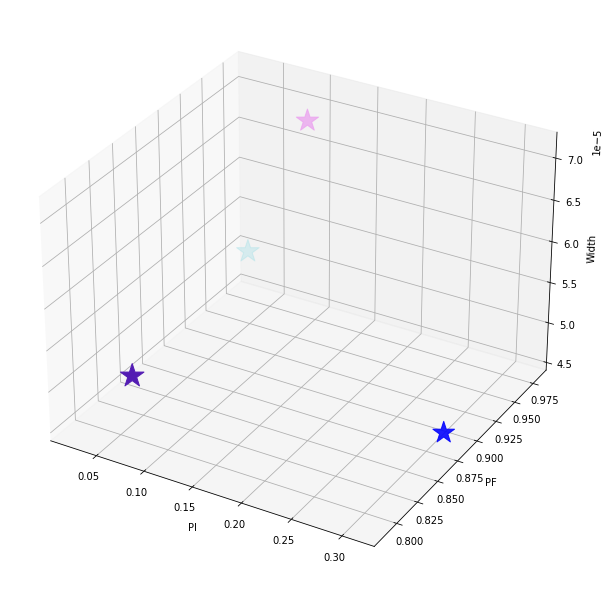

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Getting the cluster centers
C = kmeans.cluster_centers_
print(C)
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c = ['#92DCE5', 'blue', '#531cb3', '#EB9FEF'], s = C[:, 3]*1000)
ax.set_xlabel('PI')
ax.set_ylabel('PF')
ax.set_zlabel('Width')

In [ ]:
(cluster_labels == 2).sum()
pd.Series(cluster_labels).value_counts()

0    2715268
3     508642
2     239304
1     138944
dtype: int64

Text(0, 0.5, 'PI')

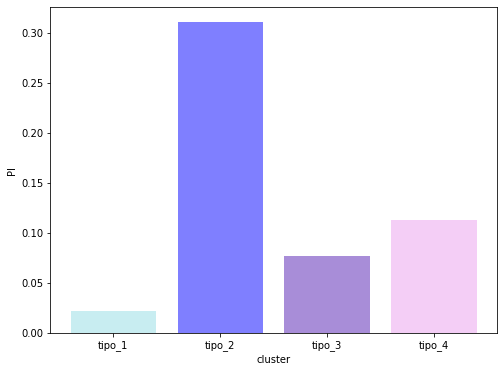

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['tipo_1','tipo_2','tipo_3','tipo_4'],C[:,0], color=['#92DCE5', 'blue', '#531cb3', '#EB9FEF'], alpha = 0.5)
plt.xlabel('cluster')
plt.ylabel('PI')

Text(0, 0.5, 'PF')

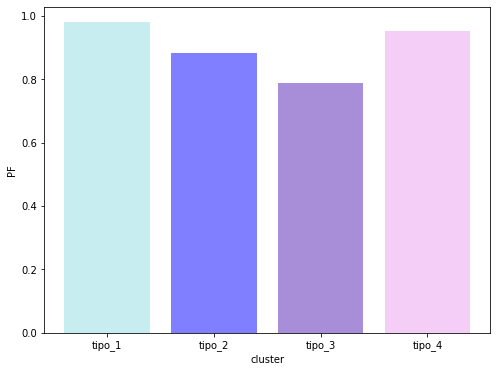

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['tipo_1','tipo_2','tipo_3','tipo_4'],C[:,1], color=['#92DCE5', 'blue', '#531cb3', '#EB9FEF'], alpha = 0.5)
plt.xlabel('cluster')
plt.ylabel('PF')

Text(0, 0.5, 'Width')

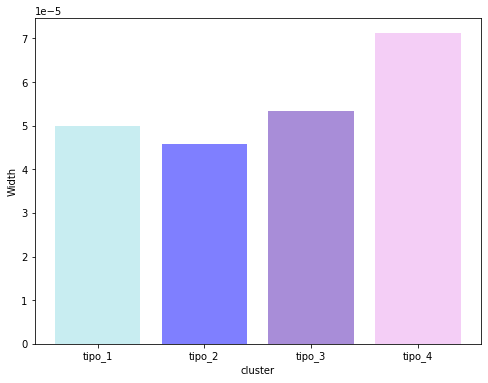

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['tipo_1','tipo_2','tipo_3','tipo_4'],C[:,2], color=['#92DCE5', 'blue', '#531cb3', '#EB9FEF'], alpha = 0.5)
plt.xlabel('cluster')
plt.ylabel('Width')

Text(0, 0.5, 'Height')

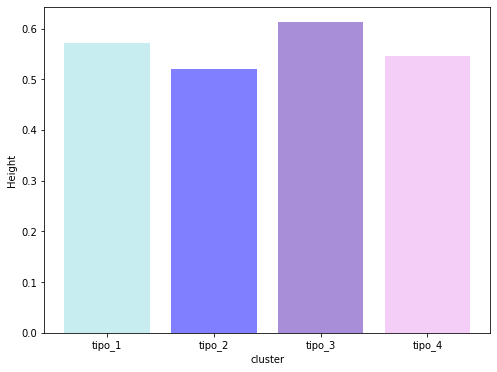

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['tipo_1','tipo_2','tipo_3','tipo_4'],C[:,3], color=['#92DCE5', 'blue', '#531cb3', '#EB9FEF'], alpha = 0.5)
plt.xlabel('cluster')
plt.ylabel('Height')

# Segunda parte - Modelos Supervisados

## Procesamiento de datos

### Formulas auxiliares

In [ ]:
def butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], 'bandpass', analog = False)
    y = lfilter(b, a, data, axis = 0)
    return y

def leer_archivo(url):
    data = mne.io.read_raw_edf(url, preload=True)
    raw_data = data.get_data()
    raw_data_FP1_FP7 = raw_data[0]
    return raw_data_FP1_FP7
def generar_Particion( data, tiempo, minutos = 60):
    resultado = []
    n_registros = len(data)/(256*minutos)
    
    for i in range(0,int(n_registros),tiempo):
        resultado.append(data[i*256*minutos:(i+tiempo)*256*minutos])
    return resultado

def detectar_picos_parte2(data):
    peaks = []
    peaks_pos = find_peaks(data,height=0.00005) #height=0.00005
    peaks_neg = find_peaks(-data,height=0.00005)
    x = np.concatenate((peaks_pos[0], peaks_neg[0]))
    x = np.sort(x)
    peaks.append(x)
    return peaks


def segmentacion_picos_parte2(raw_data, peaks):
    resultados = []
    for i in range(len(peaks)-1):
        if raw_data[peaks[i]] >0 and raw_data[peaks[i+1]] <0:
            resultados.append([peaks[i],peaks[i+1]])
      
    return resultados
def denoising_parte2(data):
    N = 10  # Filter order
    Wn = 0.3  # Cutoff frequency
    B, A = sci.signal.butter(N, Wn, output='ba')
    smooth_data = sci.signal.filtfilt(B, A, data)
    
    return smooth_data

def caracterizacion_picos_parte2(raw_data, resultados):
   
    
    
    positive_peaks = np.array(resultados)[ :,0]
    
  
    ws = peak_widths(raw_data, positive_peaks, rel_height=0.5)
    prominences = peak_prominences(raw_data, positive_peaks)[0]
    contour_heights = raw_data[positive_peaks] - prominences
    
   
    
    return (ws,prominences,contour_heights)
        
        
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp
    
    

### Procesamiento de archivos 

In [ ]:
url = 'C:\\Users\\ASUS\\Desktop\\Seizures files part1\\chb01_03.edf'
chb01_03 = leer_archivo(url)
samples = generar_Particion(chb01_03)
picos_samples = detectar_picos_parte2(samples[0])
espigas = segmentacion_picos_parte2(samples[0],picos_samples[0])

Extracting EDF parameters from C:\Users\ASUS\Desktop\Seizures files part1\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-41-039d39713fcf>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(url, preload=True)


#### Extracción de features

In [ ]:
%matplotlib inline
sf = 256
### Features 
#numero_picos = len(picos_samples)
#numero_espigas = len(espigas)
### Separación por frecuencias 
# Ondas alpha
y_alpha= butter_bandpass(samples[0], 8, 13.99, 256,5)
alpha_power = bandpower(y_alpha, sf, [ 8, 13.99],'welch', None, False)

# Ondas Betha                     
y_betha= butter_bandpass(samples[0], 14, 30, 256,5)
betha_power = bandpower(y_alpha, sf, [ 14, 30],'welch', None, False)
           
# Ondas Gamma                     
y_gamma= butter_bandpass(samples[0], 25, 100, 256,5)
gamma_power = bandpower(y_alpha, sf, [ 25, 100],'welch', None, False)
                     
# Ondas Theta
y_theta= butter_bandpass(samples[0], 4, 7.99, 256,5)
tetha_power = bandpower(y_alpha, sf, [ 4, 7.99],'welch', None, False)
                     
# Ondas Delta                    
#badpower(data, sf, band, method='welch', window_sec=None, relative=False)
y_delta= butter_bandpass(samples[0], 0.1, 3.99, 256,5)
delta_power = bandpower(y_alpha, sf, [ 0.1, 3.99],'welch', None, False)

print(delta_power)
print(gamma_power)
print(betha_power)
print(tetha_power)

1.8641576150244627e-17
9.15406513909759e-12
4.255524519813762e-11
1.0854652586806901e-12


In [ ]:
def procesar_datos_parte2(raw_data):
    raw_data = denoising_parte2(raw_data)  #### Denosing the data
    peaks = detectar_picos_parte2(raw_data) ## Detecting the peaks in the signals given the specifications 
        
    if len(peaks[0]) > 0:
        resultados = segmentacion_picos_parte2(raw_data, peaks[0]) ## Selects only the spikes with positive then negative peak
        if len(resultados) > 0:
            caracterizacion = caracterizacion_picos_parte2(raw_data, resultados)## Extracts features from the spikes
            resultados = np.array(resultados)
            indices_pos = resultados[:,0]
            indices_neg = resultados[:,1]
            vals_pos = raw_data[indices_pos]
            vals_neg = raw_data[indices_neg]
            widths   =  caracterizacion[0][0]
            heights  =  caracterizacion[2]
            d = {'Peak_I': vals_pos, 'Peak_F': vals_neg, 'Width': widths,'Height': heights }#, 'N_channel': numero_archivo } #'Prominence': prominences, }
            df_inicial= pd.DataFrame(data=d)     
            ## Se normalizan los datos
            x_scaled = min_max_scaler.transform(df_inicial)
            df_normalized = pd.DataFrame(x_scaled, columns = ['Peak_I','Peak_F','Width','Height'])
        
            ### Integracion con clustering 
            espigas_clasificadas = kmeans.predict(df_normalized) 
            espigas1 = (espigas_clasificadas == 0).sum() #espigas_clasificadas.count(0)
            espigas2 = (espigas_clasificadas == 1).sum() 
            espigas3 = (espigas_clasificadas == 2).sum() 
            espigas4 = (espigas_clasificadas == 3).sum()   
            ### Features para clasificacion
            numero_picos   =  len(peaks[0])
            numero_espigas =  df_inicial.shape[0]
            
                
            ##### Procesamiento de las ondas 
            sf = 256
            ### Features 
            y_alpha= butter_bandpass(raw_data, 8, 13.99, 256,5)
            alpha_power = bandpower(y_alpha, sf, [ 8, 13.99],'welch', None, False)
            # Ondas Betha                     
            y_betha= butter_bandpass(raw_data, 14, 30, 256,5)
            betha_power = bandpower(y_betha, sf, [ 14, 30],'welch', None, False)
            # Ondas Gamma                     
            y_gamma= butter_bandpass(raw_data, 25, 100, 256,5)
            gamma_power = bandpower(y_gamma, sf, [ 25, 100],'welch', None, False)         
            # Ondas Theta
            y_theta= butter_bandpass(raw_data, 4, 7.99, 256,5)
            tetha_power = bandpower(y_theta, sf, [ 4, 7.99],'welch', None, False)          
            # Ondas Delta                    
            #badpower(data, sf, band, method='welch', window_sec=None, relative=False)
            y_delta= butter_bandpass(raw_data, 0.1, 3.99, 256,5)
            delta_power = bandpower(y_delta, sf, [ 0.1, 3.99],'welch', None, False)
            
            return (numero_picos,numero_espigas,espigas1,espigas2,espigas3,alpha_power,betha_power,gamma_power,tetha_power,delta_power,espigas4)
  

# Procesamiento de archivos normales

In [ ]:
n_picos =           []
n_espigas =         []
n_espigas_1 =       []
n_espigas_2 =       []
n_espigas_3 =       []
n_espigas_4 =       []
datos_banda_alpha = []
datos_banda_betha = []
datos_banda_gamma = []
datos_banda_tetha = []
datos_banda_delta = []
etiquetas = []
import os,glob
folder_path = 'C:\\Users\\ASUS\\Desktop\\Seizures files part1'
for filename in glob.glob(os.path.join(folder_path, '*.edf')): 
    vals_pos = []
    vals_neg = []
    widths =   []
    heights =  []
    #numero_archivo = []
    
    
    data = mne.io.read_raw_edf(filename, preload=True) 
    raw_data = data.get_data() ##Lectura de datos 
    raw_data = raw_data[0] ##Lectura de datos 
    
    """
    HERE
    """
    particiones = generar_Particion(raw_data, 5, 1) ### Lo particiona en ventanas
    
    for k in particiones:
        procesados = procesar_datos_parte2(k)
        if procesados  is not None:
            n_picos.append(procesados[0])
            n_espigas.append(procesados[1])
            n_espigas_1.append(procesados[2])
            n_espigas_2.append(procesados[3])
            n_espigas_3 .append(procesados[4])
            datos_banda_alpha.append(procesados[5])
            datos_banda_betha.append(procesados[6])
            datos_banda_gamma.append(procesados[7])
            datos_banda_tetha.append(procesados[8])
            datos_banda_delta.append(procesados[9])
            n_espigas_4 .append(procesados[10])
            etiquetas.append('normal')    
    
    

# Procesamiento de archivos con seizures

In [ ]:
n_picos =           []
n_espigas =         []
n_espigas_1 =       []
n_espigas_2 =       []
n_espigas_3 =       []


n_espigas_4 =       []

datos_banda_alpha = []
datos_banda_betha = []
datos_banda_gamma = []
datos_banda_tetha = []
datos_banda_delta = []
etiquetas = []

In [ ]:
import os,glob
folder_path = 'C:\\Users\\ASUS\\Desktop\\Nueva carpeta'
for filename in glob.glob(os.path.join(folder_path, '*.edf')): 
    vals_pos = []
    vals_neg = []
    widths =   []
    heights =  []
    #numero_archivo = []
    
    
    data = mne.io.read_raw_edf(filename, preload=True) 
    raw_data = data.get_data() ##Lectura de datos 
    raw_data = raw_data[0] ##Lectura de datos                
    
    inicio = int(input('incio')) *  256
    final = int(input('final')) *  256
    
    pre_ictal = raw_data[:inicio]
    ictal = raw_data[inicio : final]
    interictal = raw_data[final: ]
    
    particiones_ictal = generar_Particion(ictal, 5, 1) ### Ventans de ictal
    particiones_preictal = generar_Particion(pre_ictal, 5, 1) ### Ventans de preictal
    particiones_inter = generar_Particion(interictal, 5, 1) ### Ventans de interictal
    
    for  k in particiones_preictal:
        procesados = procesar_datos_parte2(k)
        if procesados  is not None:
            n_picos.append(procesados[0])
            n_espigas.append(procesados[1])
            n_espigas_1.append(procesados[2])
            n_espigas_2.append(procesados[3])
            n_espigas_3 .append(procesados[4])
            datos_banda_alpha.append(procesados[5])
            datos_banda_betha.append(procesados[6])
            datos_banda_gamma.append(procesados[7])
            datos_banda_tetha.append(procesados[8])
            datos_banda_delta.append(procesados[9]) 
            n_espigas_4 .append(procesados[10])
            etiquetas.append('pre_ictal')
            
    for k in  particiones_preictal:       
        procesados = procesar_datos_parte2(ictal)
        if procesados  is not None:
            n_picos.append(procesados[0])
            n_espigas.append(procesados[1])
            n_espigas_1.append(procesados[2])
            n_espigas_2.append(procesados[3])
            n_espigas_3 .append(procesados[4])
            datos_banda_alpha.append(procesados[5])
            datos_banda_betha.append(procesados[6])
            datos_banda_gamma.append(procesados[7])
            datos_banda_tetha.append(procesados[8])
            datos_banda_delta.append(procesados[9])   
            n_espigas_4 .append(procesados[10])
            etiquetas.append('ictal')
        
    for  k in particiones_inter:
        procesados = procesar_datos_parte2(k)
        if procesados  is not None:
            n_picos.append(procesados[0])
            n_espigas.append(procesados[1])
            n_espigas_1.append(procesados[2])
            n_espigas_2.append(procesados[3])
            n_espigas_3 .append(procesados[4])
            datos_banda_alpha.append(procesados[5])
            datos_banda_betha.append(procesados[6])
            datos_banda_gamma.append(procesados[7])
            datos_banda_tetha.append(procesados[8])
            datos_banda_delta.append(procesados[9])
            n_espigas_4 .append(procesados[10])
            etiquetas.append('interictal')

In [ ]:
dic = {'n_peaks': n_picos, 'n_spikes': n_espigas, 'n_spikes1': n_espigas_1,
       'n_spikes2': n_espigas_2, 'n_spikes3': n_espigas_3,'alpha_power': datos_banda_alpha, 
       'betha_power': datos_banda_betha,'gamma_power': datos_banda_gamma,
       'alpha_power': datos_banda_tetha,'delta_power': datos_banda_delta, 'label': etiquetas, 'n_spikes4':n_espigas_4 } 
df_final= pd.DataFrame(data=dic)
df_final.to_csv('C:\\Users\\ASUS\\Desktop\\Datos_seizures6.csv', index=False, header= True)
df_final

,n_peaks,n_spikes,n_spikes1,n_spikes2,n_spikes3,alpha_power,betha_power,gamma_power,delta_power,label,n_spikes4
0,88,7,7,0,0,3.982187e-10,1.367246e-10,1.625430e-10,445.592966,pre_ictal,0
1,92,9,9,0,0,5.582374e-10,3.171512e-10,2.765573e-10,97.987160,pre_ictal,0
2,71,7,7,0,0,2.274197e-10,1.008604e-10,2.170475e-10,83.923403,pre_ictal,0
3,66,7,7,0,0,1.259768e-10,1.434769e-10,2.266118e-10,10.166792,pre_ictal,0
4,53,4,4,0,0,3.803293e-10,1.344651e-10,1.228860e-10,2884.573410,pre_ictal,0
...,...,...,...,...,...,...,...,...,...,...,...
11207,112,11,10,0,0,1.514171e-09,2.138952e-09,8.021138e-10,1.361452,interictal,1
11208,53,7,7,0,0,1.185444e-10,1.089859e-10,5.437652e-11,470.010308,interictal,0
11209,89,3,3,0,0,2.473624e-10,1.083235e-10,5.373388e-11,2713.235822,interictal,0
11210,40,3,3,0,0,1.937021e-10,7.110458e-11,4.035178e-11,202.362047,interictal,0
